# Model Interpretation

In [1]:
import pandas as pd
import seaborn as sns
import eli5
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
import xgboost as xgb
from treeinterpreter import treeinterpreter
import waterfall_chart

from locusts.data import load_data, preprocess_data
from locusts.models import logistic_regression, random_forest, xgboost_regressor

shap.initjs()

In [2]:
BUCKETIZE = True
dataset = "ep_random" # or "random"
seed = 42

data_train, _ = load_data(dataset, path="../data")
data_x, data_y = preprocess_data(
    data_train, start_day=7, bucketize=BUCKETIZE
)

N = 500
train_x, val_x, train_y, val_y = train_test_split(
    data_x, data_y, test_size=N, random_state=seed
)
# TODO: split validation by time (same as test)
# train_x, val_x = data_x.iloc[:-N].reset_index(drop=True), data_x.iloc[-N:].reset_index(drop=True)
# train_y, val_y = data_y.iloc[:-N].reset_index(drop=True), data_y.iloc[-N:].reset_index(drop=True)

Train missing 0 columns
Test missing 0 columns
Objects: ['method', 'observation_date']
Categoricals: ['Unnamed: 0.1', 'presence', 'year', 'month', 'day']
Floats: ['x', 'y', 'clay_0.5cm_mean', 'clay_5.15cm_mean', 'sand_0.5cm_mean', 'sand_5.15cm_mean', 'silt_0.5cm_mean', 'silt_5.15cm_mean', 'AvgSurfT_inst_0', 'Albedo_inst_0']


In [3]:
def predition_hist(preds, targets):
    plt.hist(preds, label="Predictions")
    plt.hist(targets, label="Target", alpha=0.5)
    plt.legend()

## Logistic Regression

In [4]:
lr_model, _, _, scaler = logistic_regression(
    train_x, train_y, val_x, val_y, val_x, val_y, seed=seed, return_scaler=True
)
train_x_scaled = scaler.transform(train_x)
val_x_scaled = scaler.transform(val_x)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Prediction Histogram

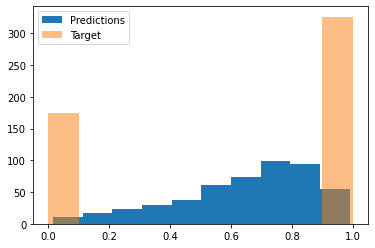

In [5]:
p = lr_model.predict_proba(val_x_scaled)[:, 1]
predition_hist(p, val_y.values)

### Feature Importance

In [6]:
w = eli5.explain_weights(lr_model, top=10, feature_names=train_x.columns.tolist())
w

Explanation(estimator='LogisticRegression(random_state=42)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='SoilTMP10_40cm_inst_bucket_14', weight=1.4545438597005922, std=None, value=None), FeatureWeight(feature='SoilTMP10_40cm_inst_bucket_2', weight=1.2265949165207946, std=None, value=None), FeatureWeight(feature='Psurf_f_inst_bucket_14', weight=1.1204003277271175, std=None, value=None), FeatureWeight(feature='SoilTMP10_40cm_inst_bucket_8', weight=0.9763247602575099, std=None, value=None), FeatureWeight(feature='SoilTMP10_40cm_inst_bucket_6', weight=0.922830067187769, std=None, value=None), FeatureWeight(feature='SoilTMP10_40cm_inst_bucket_13', weight=0.8999504650252469, std=None, value=None)], neg=[FeatureWeight(feature='Albedo_inst_bucket_14', weight=-1.93942622884667, std=None, value=None), FeatureWeight(feature='Tair_f_inst_bucket_2', weight=-1.2607805945729047, std=None, value=None), FeatureWeight(feature='Albedo_inst_bucket_13', weight=-1.097543017282167, std=None, value=None), FeatureWeight(feature='Psurf_f_inst_bucket_10', weight=-1.0630786092209592, std=None, value=None)], pos_remaining=77, neg_remaining=88), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [7]:
pos = [x.feature for x in w.targets[0].feature_weights.pos][:3]
neg = [x.feature for x in w.targets[0].feature_weights.neg][:3]

### Pairplot Datapoints of Most Positive and Most Negative Features

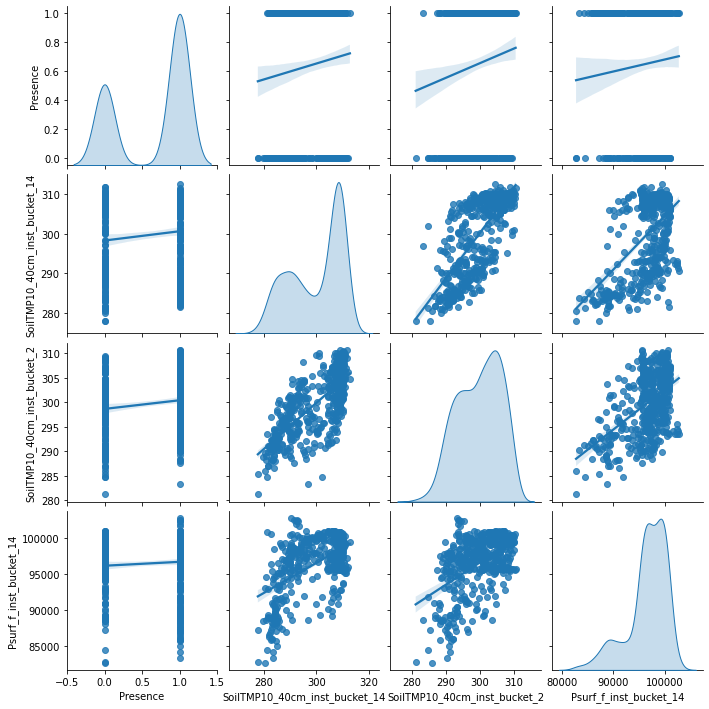

In [8]:
ds = val_x[pos]
ds.insert(0, "Presence", val_y)
sns.pairplot(ds, kind="reg", diag_kind="kde");

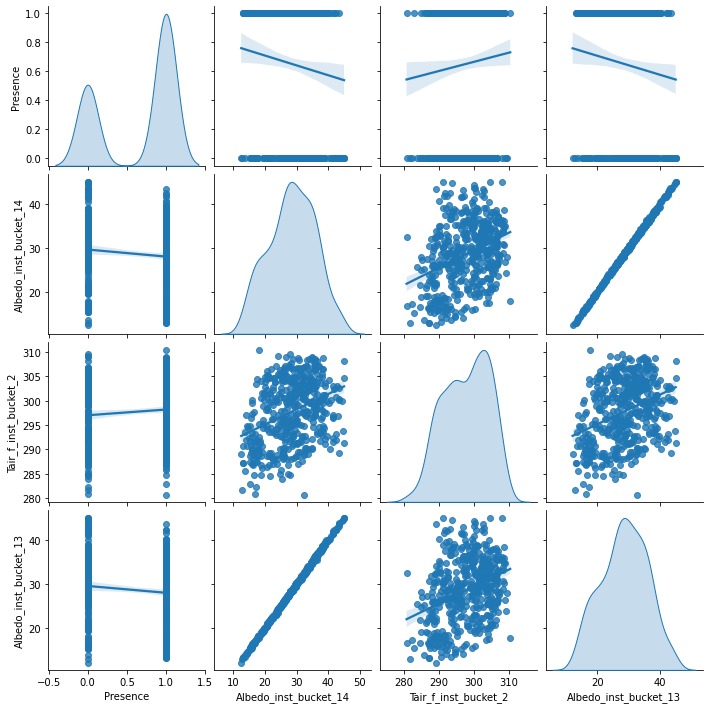

In [9]:
ds = val_x[neg]
ds.insert(0, "Presence", val_y)
sns.pairplot(ds, kind="reg", diag_kind="kde");

### Partial Dependence Plot of Most Positive and Most Negative Feature

Note: the x-axis has been scaled

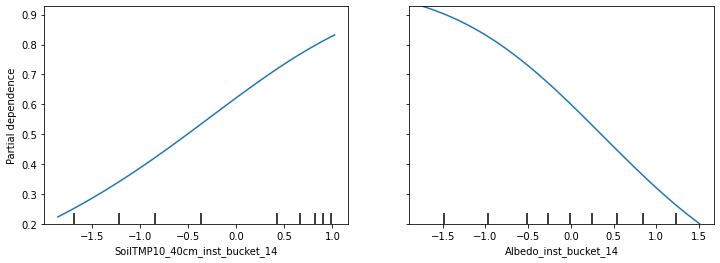

In [10]:
f, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(lr_model, val_x_scaled, 
                        ["SoilTMP10_40cm_inst_bucket_14", "Albedo_inst_bucket_14"], 
                        feature_names=val_x.columns.to_list(),
                        ax=ax)

### SHAP Values

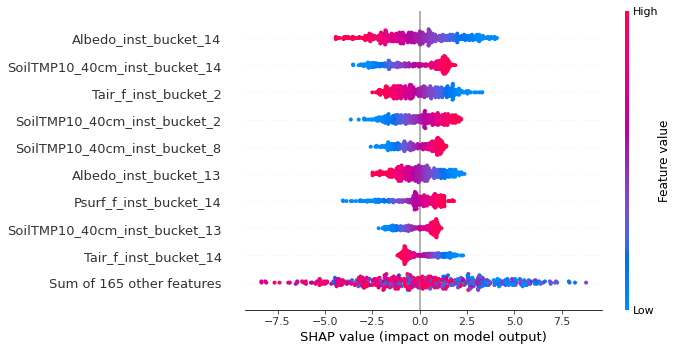

In [11]:
explainer = shap.Explainer(lr_model, train_x_scaled, feature_names=train_x.columns.tolist())
shap_values = explainer(val_x_scaled)
shap.plots.beeswarm(shap_values)

#### Explain a single example

In [12]:
ind = 0
shap.plots.force(shap_values[ind])

## XGBoost

In [13]:
xgb_model, _, _ = xgboost_regressor(
    train_x, train_y, val_x, val_y, val_x, val_y, seed=seed
)

[16:56:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Prediction Histogram

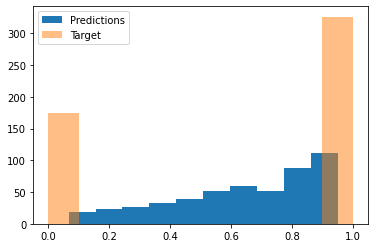

In [14]:
val_xgb = xgb.DMatrix(val_x, label=val_y)
p = xgb_model.predict(val_xgb)
predition_hist(p, val_y.values)

### Feature Importance

In [15]:
w = eli5.explain_weights(xgb_model, top=10, feature_names=train_x.columns.tolist())
w

Weight,Feature
0.0772,Psurf_f_inst_bucket_1
0.0351,SoilTMP10_40cm_inst_bucket_12
0.0321,Albedo_inst_bucket_10
0.0317,Psurf_f_inst_bucket_2
0.0280,Psurf_f_inst_bucket_5
0.0258,SoilMoi0_10cm_inst_bucket_8
0.0247,SoilTMP0_10cm_inst_bucket_12
0.0197,SoilMoi0_10cm_inst_bucket_7
0.0191,SoilTMP10_40cm_inst_bucket_2
0.0171,SoilTMP10_40cm_inst_bucket_6


### SHAP Values

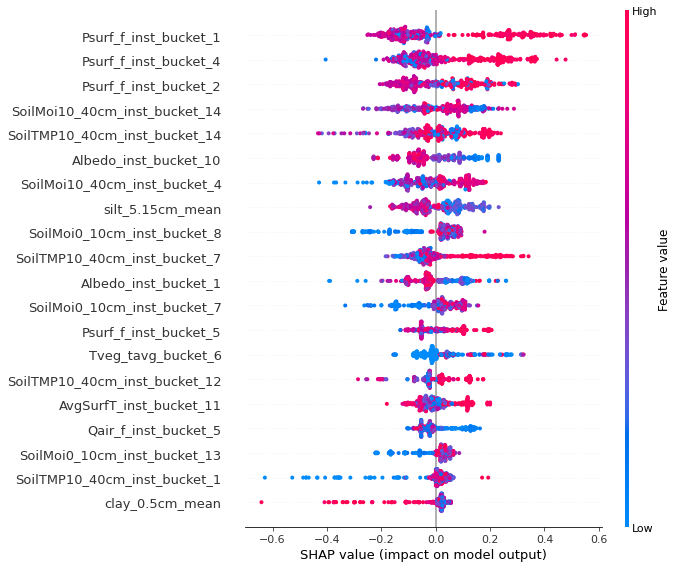

In [16]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_x)
shap.summary_plot(shap_values, val_x)

## Random Forest

In [17]:
rf_model, _, _ = random_forest(
    train_x, train_y, val_x, val_y, val_x, val_y, seed=seed
)

### Prediction Histogram

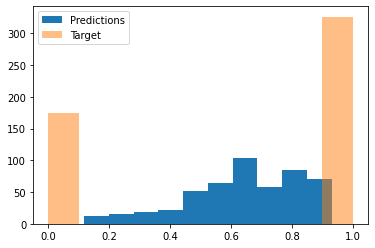

In [18]:
p = rf_model.predict_proba(val_x)[:, 1]
predition_hist(p, val_y.values)

### Feature Importance

In [19]:
w = eli5.explain_weights(rf_model, top=10, feature_names=train_x.columns.tolist())
w

Weight,Feature
0.0354 ± 0.1669,Psurf_f_inst_bucket_1
0.0287 ± 0.1509,Psurf_f_inst_bucket_4
0.0257 ± 0.1351,Psurf_f_inst_bucket_2
0.0217 ± 0.1336,Psurf_f_inst_bucket_6
0.0205 ± 0.1360,Psurf_f_inst_bucket_7
0.0202 ± 0.1260,Psurf_f_inst_bucket_12
0.0188 ± 0.1205,Psurf_f_inst_bucket_10
0.0171 ± 0.0937,SoilMoi0_10cm_inst_bucket_8
0.0170 ± 0.1138,Psurf_f_inst_bucket_9
0.0170 ± 0.0840,Albedo_inst_bucket_13


### Tree Interpreter

In [20]:
y_probs = rf_model.predict_proba(val_x)[:, 1]
errors = abs(y_probs - val_y)
rf_val_error_x = val_x.copy()
rf_val_error_x['errors'] = errors
rf_val_error_x = rf_val_error_x.sort_values('errors', ascending=False)
rf_val_error_x.head()

,AvgSurfT_inst_bucket_1,AvgSurfT_inst_bucket_2,AvgSurfT_inst_bucket_3,AvgSurfT_inst_bucket_4,AvgSurfT_inst_bucket_5,AvgSurfT_inst_bucket_6,AvgSurfT_inst_bucket_7,AvgSurfT_inst_bucket_8,AvgSurfT_inst_bucket_9,AvgSurfT_inst_bucket_10,...,Psurf_f_inst_bucket_12,Psurf_f_inst_bucket_13,Psurf_f_inst_bucket_14,sand_0.5cm_mean,sand_5.15cm_mean,clay_0.5cm_mean,clay_5.15cm_mean,silt_0.5cm_mean,silt_5.15cm_mean,errors
73201,303.289647,303.865479,307.153295,309.127299,309.514297,309.950821,310.714493,310.477885,307.422007,309.010101,...,99224.269531,99165.062500,99322.304688,536.0,525.0,247.0,256.0,217.0,219.0,0.920926
3947,301.609055,305.370148,307.183736,308.027649,307.435389,308.713435,308.664953,309.285151,309.814056,309.025757,...,99451.356771,99489.447917,99181.532552,552.0,533.0,203.0,224.0,245.0,243.0,0.918699
42793,306.364319,304.744914,308.144079,307.843953,303.623103,309.740458,309.741186,308.602442,308.776616,311.725484,...,99540.733073,99320.138021,99345.981771,627.0,622.0,152.0,157.0,221.0,221.0,0.916946
6423,299.998800,299.701686,299.068105,301.999776,303.356969,303.661540,300.958227,306.422231,308.617910,308.795568,...,100304.276042,100242.502604,100366.049479,608.0,606.0,148.0,147.0,244.0,246.0,0.913064
73146,307.046707,309.336299,309.525904,309.579987,310.745438,311.549784,308.451482,309.215327,307.894760,309.766830,...,100255.024740,100297.915365,100040.052083,626.0,616.0,234.0,247.0,141.0,137.0,0.873860


In [21]:
most_wrong = rf_val_error_x.iloc[:5].drop(columns="errors")
pred, bias, contribute = treeinterpreter.predict(rf_model, most_wrong.values)

<module 'matplotlib.pyplot' from '/home/pan/miniconda3/envs/locusts/lib/python3.9/site-packages/matplotlib/pyplot.py'>

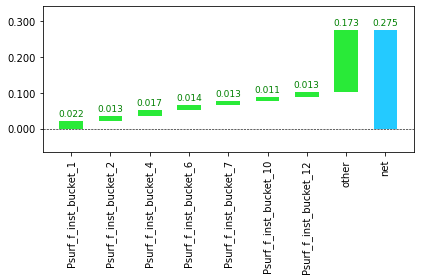

In [22]:
waterfall_chart.plot(most_wrong.columns, contribute[0][:, 1], threshold=0.5, 
                     formatting='{:,.3f}', rotation_value=90)

### SHAP Values

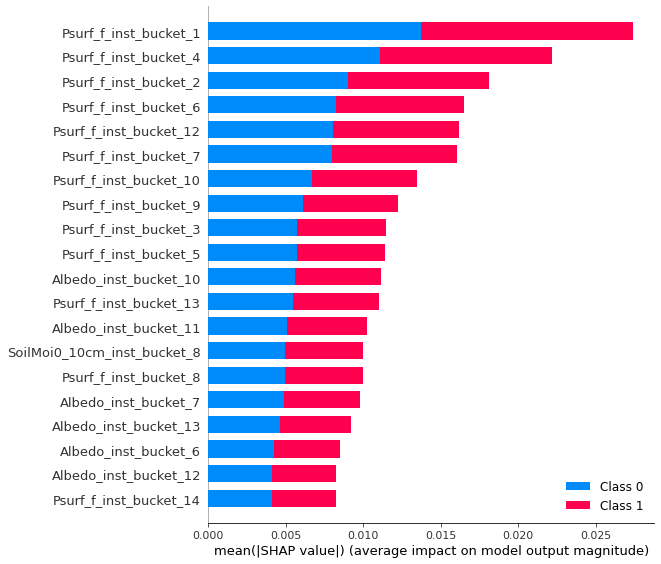

In [23]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(val_x)
shap.summary_plot(shap_values, val_x)

### Partial Dependence of Most Important Features

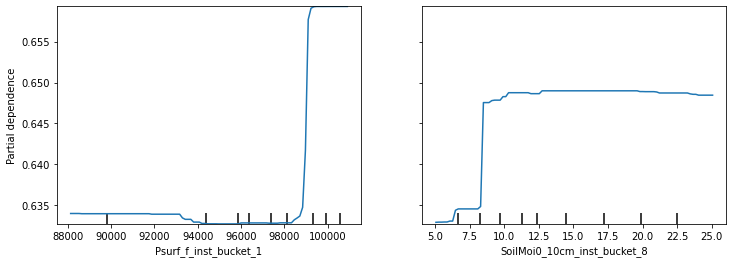

In [24]:
f, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rf_model, val_x, 
                        ["Psurf_f_inst_bucket_1", "SoilMoi0_10cm_inst_bucket_8"], 
                        ax=ax)

#### Compare Partial Dependence to Logistic Regression Model

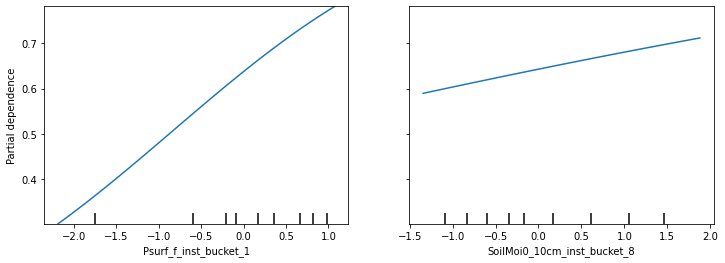

In [25]:
f, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(lr_model, val_x_scaled, 
                        ["Psurf_f_inst_bucket_1", "SoilMoi0_10cm_inst_bucket_8"], 
                        feature_names=val_x.columns.to_list(),
                        ax=ax)